# 1. Long CLIP demo

In [1]:
from model import longclip
import torch
import open_clip
from PIL import Image

import os
import sys

sys.path.append(
    "/ML-A100/team/mm/wangjiazhi/03_scripts/50_study/text_encoder/Long-CLIP"
)

longclip_l_path = (
    "/ML-A100/team/mm/wangjiazhi/20_model/HF/LongCLIP-L/longclip-L.pt"  # 427,938,305
)
longclip_b_path = "/ML-A100/team/mm/wangjiazhi/20_model/HF/LongCLIP-B/longclip-B.pt"  #
longclip_bigG_path = "/ML-A100/team/mm/gujiasheng/Long-CLIP/train/lr=1e-06_wd=0.01_wl=200_log_scale=4.6052_bs=128/ckpt/longclip-bigG_epoch_0.pt"
clip_bigG_path = (
    "/ML-A100/team/mm/gujiasheng/Long-CLIP/ViT-bigG-14-laion2b_s39b_b160k.pt"
)
device = "cuda" if torch.cuda.is_available() else "cpu"
# model, preprocess = longclip.load(longclip_l_path, device=device)
model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-bigG-14", pretrained="laion2b_s39b_b160k"
)
model.to(device)

In [12]:
prompts = [
    "A man is crossing the street with a red car parked nearby.",
    "A man is driving a car in an urban scene.",
]
# text = longclip.tokenize(prompts).to(device)
text = prompts
image = (
    preprocess(
        Image.open("/ML-A100/team/mm/gujiasheng/Long-CLIP/longclip-man-red-car.png")
    )
    .unsqueeze(0)
    .to(device)
)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    text_features_full = model.encode_text_full(text)

    image_features, text_features, logit_scale = model(image, text)

    logits_per_image = torch.matmul(image_features, text_features.T)
    logits_per_image = logit_scale * logits_per_image
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.982  0.01799]]

ValueError: too many dimensions 'str'

In [6]:
image_features.shape

torch.Size([1, 1280])

In [ ]:
import clip

_, preprocess = clip.load("ViT-L/14")

In [13]:
import open_clip

model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-bigG-14", pretrained="laion2b_s39b_b160k"
)

In [6]:
image = (
    preprocess(Image.open("/ML-A100/team/mm/gujiasheng/Long-CLIP/img/demo.png"))
    .unsqueeze(0)
    .to(device)
)

In [40]:
print(text.shape)
print(model.__dict__.keys())
print(model.__dict__["vocab_size"])  # 49408, same as clip
text_features = model.encode_text(text)
print(text_features.shape)
print(text_features_full.shape)

torch.Size([2, 248])
dict_keys(['training', '_parameters', '_buffers', '_non_persistent_buffers_set', '_backward_pre_hooks', '_backward_hooks', '_is_full_backward_hook', '_forward_hooks', '_forward_hooks_with_kwargs', '_forward_hooks_always_called', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_state_dict_hooks', '_state_dict_pre_hooks', '_load_state_dict_pre_hooks', '_load_state_dict_post_hooks', '_modules', 'context_length', 'vocab_size', 'mask1', 'mask2'])
49408
torch.Size([2, 768])
torch.Size([2, 248, 768])


In [41]:
params_cnt = 0
for name, param in model.named_parameters():
    # print(name, param.size())
    params_cnt += param.numel()
print(f"Total params: {params_cnt:,}")

Total params: 427,938,305


# 2. Original CLIP-L

In [42]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5EncoderModel
from transformers import CLIPTextModel, CLIPTextModelWithProjection

SDXL_base_path = "/ML-A100/team/mm/wangjiazhi/20_model/snapshot_download/models/stable-diffusion-xl-base-1.0"

tokenizer_one = AutoTokenizer.from_pretrained(
    SDXL_base_path, subfolder="tokenizer", revision=None, use_fast=False
)
tokenizer_two = AutoTokenizer.from_pretrained(
    SDXL_base_path,
    subfolder="tokenizer_2",
    revision=None,
    use_fast=False,
    ignore_mismatched_sizes=True,
)

for tokenizer in [tokenizer_one, tokenizer_two]:
    print(tokenizer.vocab_size)
    print(len(tokenizer))

text_encoder_one = CLIPTextModel.from_pretrained(
    SDXL_base_path,
    subfolder="text_encoder",
    revision=None,
    ignore_mismatched_sizes=True,
)
text_encoder_two = CLIPTextModelWithProjection.from_pretrained(
    SDXL_base_path,
    subfolder="text_encoder_2",
    revision=None,
    ignore_mismatched_sizes=True,
)

49408
49408
49408
49408


In [43]:
text_inputs = tokenizer_one(
    prompts,
    padding="max_length",
    max_length=tokenizer_one.model_max_length,  # CLIPTokenizer.model_max_length is 77
    truncation=True,
    return_tensors="pt",
    return_length=True,
)  # text_inputs['input_ids'].shape is torch.Size([B, max_lenght])
print(text_inputs["input_ids"].shape)

outputs_1 = text_encoder_one(text_inputs["input_ids"], output_hidden_states=True)
pooled_prompt_embeds_1 = (
    outputs_1.text_embeds if "text_embeds" in outputs_1 else outputs_1.pooler_output
)
print(pooled_prompt_embeds_1.shape)

torch.Size([2, 77])
torch.Size([2, 768])


## 2.1 similarity with longCLIP

In [44]:
print(pooled_prompt_embeds_1.shape, text_features.shape)

import torch.nn.functional as F

# similarity betweeen pooled_prompt_embeds_1 and text_features
similarity = F.cosine_similarity(
    pooled_prompt_embeds_1.cpu(), text_features.cpu(), dim=-1
)
print(similarity)

cosine_similarity = F.cosine_similarity(
    pooled_prompt_embeds_1.to("cpu"), text_features.to("cpu"), dim=1
)
print(cosine_similarity)

torch.Size([2, 768]) torch.Size([2, 768])
tensor([-0.0483, -0.0357], grad_fn=<SumBackward1>)
tensor([-0.0483, -0.0357], grad_fn=<SumBackward1>)


# 3. longCLIP for SDXL

In [8]:
from diffusers import DiffusionPipeline
import torch

SDXL_base_path = "/ML-A100/team/mm/wangjiazhi/20_model/snapshot_download/models/stable-diffusion-xl-base-1.0"
device = "cuda:3"

pipe = DiffusionPipeline.from_pretrained(
    SDXL_base_path,
    torch_dtype=torch.float16,
    variant="fp16",
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

## 3.1 Original SDXL pipeline

In [23]:
img_w, img_h = 1024, 1024
guidance_scale = 7
num_images_per_prompt = 1
infer_steps = 30
SEED = 666

prompts = ["One cat and two dogs sitting on the grass."]
prompts = [
    "New York Skyline with 'Deep Learning' written with fireworks on the sky.",
    "One cat and two dogs sitting on the grass.",
] + [
    "A man is crossing the street with a red car parked nearby.",
    "A man is driving a car in an urban scene.",
]
# prompts = [prompts[0]]
# prompts = prompts[::-1]

seed_gen = torch.Generator("cuda").manual_seed(
    SEED
)  # must be here, since 'seed_gen' would be updated each time a random number is generated
images_ori = pipe(
    prompt=prompts,
    negative_prompt=None,
    width=img_w,
    height=img_h,
    guidance_scale=guidance_scale,
    generator=seed_gen,
    num_images_per_prompt=num_images_per_prompt,
    num_inference_steps=infer_steps,
).images

  0%|          | 0/30 [00:00<?, ?it/s]

4


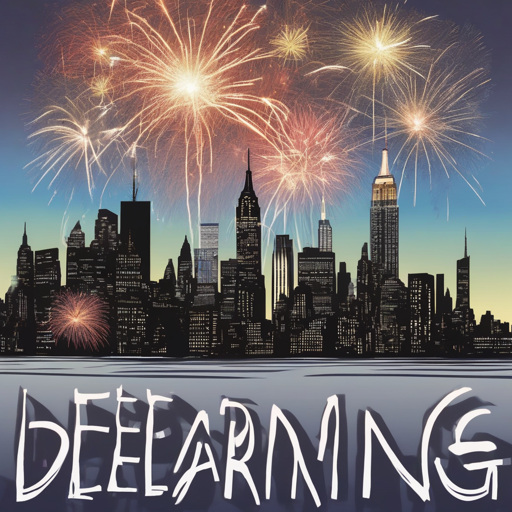

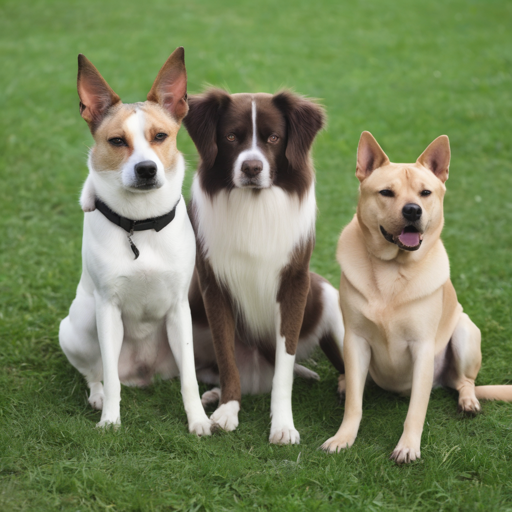

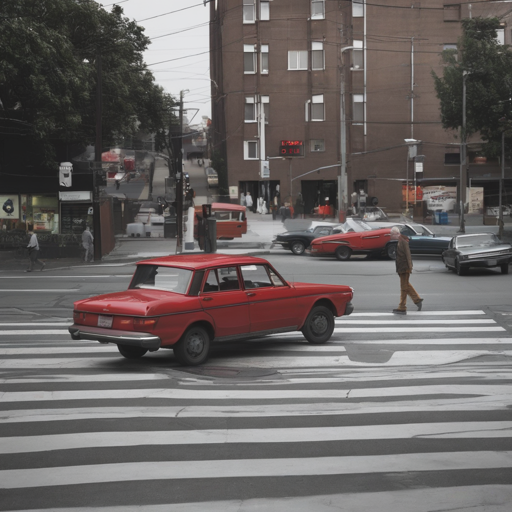

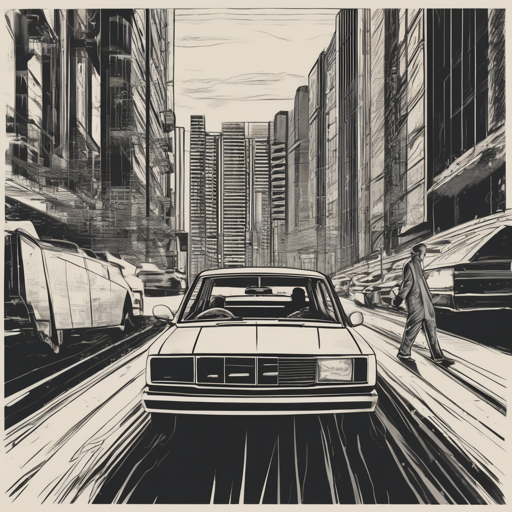

In [26]:
from IPython.display import display

print(len(images_ori))
for img in images_ori:
    img.thumbnail((512, 512))  # set max width and height and keep the aspect ratio
    display(img)

## 3.2 use longCLIP text embeddings to replace CLIP-L
### (1) get longCLIP embeddings

In [2]:
from model import longclip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
longclip_l_path = (
    "/ML-A100/team/mm/wangjiazhi/20_model/HF/LongCLIP-L/longclip-L.pt"  # 427,938,305
)
longclip_b_path = "/ML-A100/team/mm/wangjiazhi/20_model/HF/LongCLIP-B/longclip-B.pt"  #

model, preprocess = longclip.load(longclip_l_path, device=device)

In [3]:
prompts = [
    "4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, New York Skyline with 'Deep Learning' written with fireworks on the sky.",
    "One cat and two dogs sitting on the grass.",
] + [
    "A man is crossing the street with a red car parked nearby.",
    "A man is driving a car in an urban scene.",
]
print(prompts)
text_long = longclip.tokenize(prompts)
for i in range(text_long.shape[0]):
    t = text_long[i].clone()

    # 设置触发值为 a
    a = 49407

    # 找到第一个等于a的位置
    trigger_index = (t == a).nonzero(as_tuple=True)[-1].item()

    # 创建一个掩码，该掩码在触发索引之后为True
    mask = torch.arange(len(t)) > trigger_index

    # 应用掩码，将a之后的所有0元素设置为-1
    t[mask & (t == 0)] = a
    text_long[i] = t
    # print(t)
text_long = text_long.to(device)
(
    text_features_long_x,
    text_features_long_i,
    text_features_long_pooled,
) = model.encode_text_inference(
    text_long, intermediate_output=-2, final_layer_norm_intermediate=False
)
text_features_long_i[0]

["4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, New York Skyline with 'Deep Learning' written with fireworks on the sky.", 'One cat and two dogs sitting on the grass.', 'A man is crossing the street with a red car parked nearby.', 'A man is driving a car in an urban scene.']


tensor([[-3.6641, -2.3203,  4.7305,  ...,  1.2119, -2.0547, -1.4619],
        [ 0.3777,  0.1902, -0.0945,  ...,  0.6572,  0.9346, -0.5566],
        [ 1.3330,  0.8369,  0.8149,  ...,  1.1621, -0.0158, -1.1191],
        ...,
        [ 0.2288,  0.6982,  0.0533,  ..., -0.3074, -0.1510,  0.0769],
        [ 0.2206,  0.7046,  0.0590,  ..., -0.3057, -0.1456,  0.0598],
        [ 0.2128,  0.7114,  0.0634,  ..., -0.3003, -0.1406,  0.0427]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)

In [4]:
longclip_bigG_path = "/ML-A100/team/mm/gujiasheng/Long-CLIP/train/lr=1e-06_wd=0.01_wl=200_log_scale=4.6052_bs=128/ckpt/longclip-bigG_epoch_5.pt"

device = "cuda" if torch.cuda.is_available() else "cpu"
model_bigG, preprocess = longclip.load(longclip_bigG_path, device=device)

In [5]:
prompts = [
    "4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, New York Skyline with 'Deep Learning' written with fireworks on the sky.",
    "One cat and two dogs sitting on the grass.",
] + [
    "A man is crossing the street with a red car parked nearby.",
    "A man is driving a car in an urban scene.",
]
print(prompts)
text_long = longclip.tokenize(prompts)
for i in range(text_long.shape[0]):
    t = text_long[i].clone()

    # 设置触发值为 a
    a = 49407

    # 找到第一个等于a的位置
    trigger_index = (t == a).nonzero(as_tuple=True)[-1].item()

    # 创建一个掩码，该掩码在触发索引之后为True
    mask = torch.arange(len(t)) > trigger_index

    # 应用掩码，将a之后的所有0元素设置为-1
    t[mask & (t == 0)] = a
    text_long[i] = t
    # print(t)
text_long = text_long.to(device)
(
    text_features_long_bigG_x,
    text_features_long_bigG_i,
    text_features_long_bigG_pooled,
) = model_bigG.encode_text_inference(
    text_long, intermediate_output=-2, final_layer_norm_intermediate=False
)


["4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece,4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, 4k, masterpiece, New York Skyline with 'Deep Learning' written with fireworks on the sky.", 'One cat and two dogs sitting on the grass.', 'A man is crossing the street with a red car parked nearby.', 'A man is driving a car in an urban scene.']


### (2) CLIP-G use original

In [99]:
from transformers import AutoTokenizer, PretrainedConfig

from transformers import CLIPTextModelWithProjection


def import_model_class_from_model_name_or_path(
    pretrained_model_name_or_path: str,
    revision: str = None,
    subfolder: str = "text_encoder",
):
    text_encoder_config = PretrainedConfig.from_pretrained(
        pretrained_model_name_or_path, subfolder=subfolder, revision=revision
    )
    model_class = text_encoder_config.architectures[0]

    if model_class == "CLIPTextModel":
        from transformers import CLIPTextModel

        return CLIPTextModel
    elif model_class == "CLIPTextModelWithProjection":
        from transformers import CLIPTextModelWithProjection

        return CLIPTextModelWithProjection
    else:
        raise ValueError(f"{model_class} is not supported.")


SDXL_base_path = "/ML-A100/team/mm/wangjiazhi/20_model/snapshot_download/models/stable-diffusion-xl-base-1.0"

# Load the tokenizers
tokenizer_one = AutoTokenizer.from_pretrained(
    SDXL_base_path,
    subfolder="tokenizer",
    use_fast=False,
)
tokenizer_two = AutoTokenizer.from_pretrained(
    SDXL_base_path,
    subfolder="tokenizer_2",
    use_fast=False,
)

# import correct text encoder classes
text_encoder_cls_one = import_model_class_from_model_name_or_path(SDXL_base_path)
text_encoder_cls_two = import_model_class_from_model_name_or_path(
    SDXL_base_path, subfolder="text_encoder_2"
)

text_encoder_one = text_encoder_cls_one.from_pretrained(
    SDXL_base_path, subfolder="text_encoder"
)
text_encoder_two = text_encoder_cls_two.from_pretrained(
    SDXL_base_path, subfolder="text_encoder_2"
)

text_encoder_one.requires_grad_(False)
text_encoder_two.requires_grad_(False)

text_encoder_one.to(device)
text_encoder_two.to(device)


def tokenize_prompt(tokenizer, prompt):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    return text_input_ids


with torch.no_grad():
    text_input_ids_2 = tokenize_prompt(tokenizer_two, prompts)

    outputs_2 = text_encoder_two(
        text_input_ids_2.to(text_encoder_two.device),
        output_hidden_states=True,
        return_dict=True,
    )
    print(outputs_2.keys())
    assert isinstance(text_encoder_two, CLIPTextModelWithProjection)
    pooled_prompt_embeds_2 = (
        outputs_2.text_embeds if "text_embeds" in outputs_2 else outputs.pooler_output
    )

    prompt_embeds_2 = outputs_2.hidden_states[-2]

print(
    f"prompt_embeds_two {prompt_embeds_2.shape}, pooled_prompt_embed_two {pooled_prompt_embeds_2.shape}"
)

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.


odict_keys(['text_embeds', 'last_hidden_state', 'hidden_states'])
prompt_embeds_two torch.Size([4, 77, 1280]), pooled_prompt_embed_two torch.Size([4, 1280])


### (3) start to concat

In [6]:
from torch.functional import F

text_features_full_long = text_features_long_i
text_features_full_long_bigG = text_features_long_bigG_i
maxT = max(text_features_full_long_bigG.shape[1], text_features_full_long.shape[1])
print(text_features_full_long_bigG.shape[1], text_features_full_long.shape[1], maxT)
print(text_features_full_long_bigG[0][76])

## padding prompt_embeds_2
# if text_features_full_long_bigG.shape[1] < maxT:
#     text_features_full_long_bigG = F.pad(
#         text_features_full_long_bigG,
#         (0, 0, 0, maxT - text_features_full_long_bigG.shape[1]),
#         value=0,
#     )
#     print(text_features_full_long_bigG.shape)

## do concat at dimension dim
prompt_embeds = torch.concat(
    [text_features_full_long, text_features_full_long_bigG], dim=-1
)
print("after concat, ", prompt_embeds.shape)

248 248 248
tensor([ 0.2230, -0.5332,  1.0869,  ..., -0.0501, -0.7607,  0.2839],
       device='cuda:0', dtype=torch.float16, grad_fn=<SelectBackward0>)
after concat,  torch.Size([4, 248, 2048])


# SD1.5 generate

In [11]:
from diffusers import StableDiffusionPipeline
import torch

img_w, img_h = 1024, 1024
guidance_scale = 7
num_images_per_prompt = 1
infer_steps = 30
SEED = 666
seed_gen = torch.Generator("cuda").manual_seed(
    SEED
)  # must be here, since 'seed_gen' would be updated each time a random number is generated

model_id = "/ML-A100/team/mm/gujiasheng/model/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [10]:
image = pipe(
    prompt=prompts,
    width=img_w,
    height=img_h,
    guidance_scale=1,
    generator=seed_gen,
    num_images_per_prompt=num_images_per_prompt,
    num_inference_steps=infer_steps,
).images[0]

image.save("sd1_4.png")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


  0%|          | 0/30 [00:00<?, ?it/s]

# SDXL generate


In [10]:
img_w, img_h = 1024, 1024
guidance_scale = 7
num_images_per_prompt = 1
infer_steps = 30
SEED = 666
seed_gen = torch.Generator("cuda").manual_seed(
    SEED
)  # must be here, since 'seed_gen' would be updated each time a random number is generated
images_long = pipe(
    prompt_embeds=prompt_embeds[:, :77, :],
    pooled_prompt_embeds=text_features_long_bigG_pooled,
    # prompt="New York Skyline with 'Deep Learning' written with fireworks on",
    negative_prompt=None,
    width=img_w,
    height=img_h,
    guidance_scale=guidance_scale,
    generator=seed_gen,
    num_images_per_prompt=num_images_per_prompt,
    num_inference_steps=infer_steps,
).images

print(len(images_long))
for i, img in enumerate(images_long):
    img.thumbnail((512, 512))  # set max width and height and keep the aspect ratio
    print(prompts[i])
    display(img)

ValueError: If `prompt_embeds` are provided, `pooled_prompt_embeds` also have to be passed. Make sure to generate `pooled_prompt_embeds` from the same text encoder that was used to generate `prompt_embeds`.

In [1]:
import torch

state_dict = torch.load(
    "/ML-A100/team/mm/gujiasheng/Long-CLIP/train/lr=1e-06_wd=0.01_wl=200_log_scale=4.6052_bs=128/ckpt/longclip-bigG_epoch_0.pt"
)

In [3]:
import torch
mask = torch.empty(32,32)
mask.fill_(float("-inf"))
mask.triu_(1)  # zero out the lower diagonal

tensor([[0., -inf, -inf,  ..., -inf, -inf, -inf],
        [0., 0., -inf,  ..., -inf, -inf, -inf],
        [0., 0., 0.,  ..., -inf, -inf, -inf],
        ...,
        [0., 0., 0.,  ..., 0., -inf, -inf],
        [0., 0., 0.,  ..., 0., 0., -inf],
        [0., 0., 0.,  ..., 0., 0., 0.]])